In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt #for making figures
%matplotlib inline 

In [2]:
# read in all the words 
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
#build the dataset

block_size = 3 #context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited 
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # put 27 characters in 10 dimensional space
# block size input of characters in 10 dimensional space to 200 hidden layers
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # gain/sqrt(fan_in) - kaiming_normal_  ##0.2  
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
# there is no use in bias when we use batch norm as it will be subtracted in calculation of mean :P
# instead we now have bnbias which is in charge how much we need to shift !!!
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01# output layer returning vocab size to predict symbol
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

NameError: name 'b1' is not defined

tensor(-0.0112) tensor(1.0017)
tensor(-0.0031) tensor(1.0022)


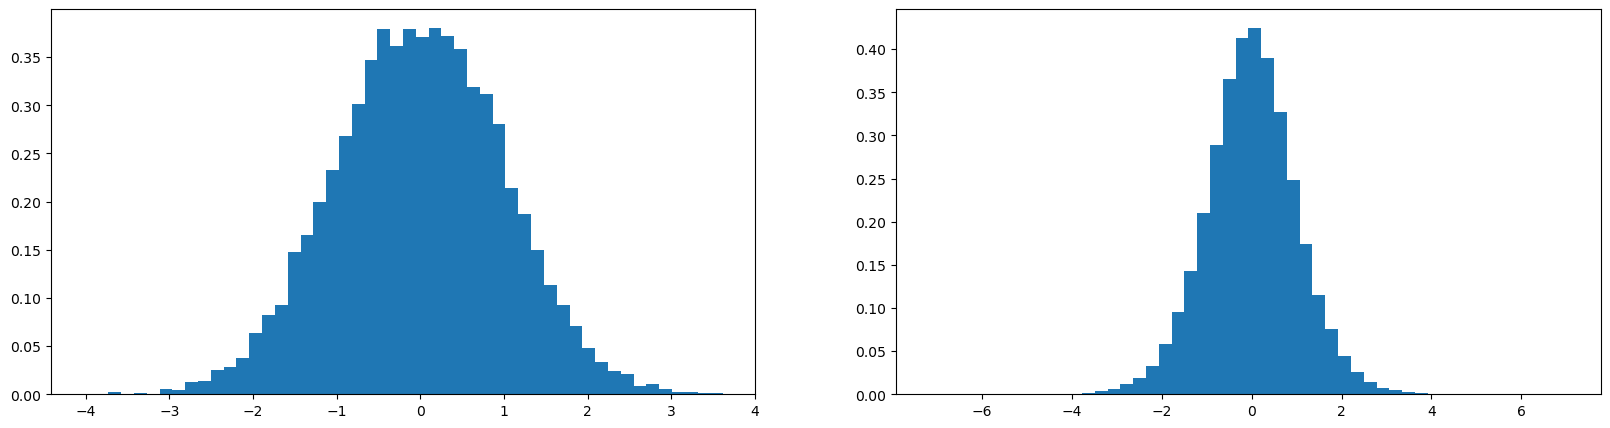

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # divide by square root of 10 the input to keep the std close to 1 wow 
# WOW #Kaiming init 1/sqrt(fan_in) -> what we have yes/ in paper for RELU sqrt(2/fan_in) its all about gain/sqrt(fan_in)
# where gain depends on the non-linerality used https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain 
# kaiming_normal_ in pytorch also can choose fan_in or fan_out -> 200 in above case
# this is less important with modern innovations
y = x @ w 
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [20]:
# print(hpreact.shape)
# print(hpreact.mean(0, keepdim=True).shape)
# print(hpreact.std(0, keepdim=True).shape)

torch.Size([32, 200])

In [ ]:
# same optimization as last time 
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  # take random 32 examples to use in training
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # [32,3,10] - embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors - [32, 30]
    # Linear layer
    hpreact = embcat @ W1 # + b1 # hidden layer pre activation 
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias #batch normalization (x - mean)/ std
    # we also want scale and shift in future, not always have gausssian distribution, so we add bngain and bnbias to be able learn to shift neurons
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer (32, 200)
    logits = h @ W2 + b2 # output layer (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Yb) # above simply rewritten loss function 
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update 
    lr = 0.01 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.2824
  20000/ 200000: 2.4047
  30000/ 200000: 2.6029
  40000/ 200000: 1.9978
  50000/ 200000: 2.5340
  60000/ 200000: 2.4879
  70000/ 200000: 2.0455
  80000/ 200000: 2.2525
  90000/ 200000: 2.1438
 100000/ 200000: 2.1007
 110000/ 200000: 2.3819
 120000/ 200000: 2.0262
 130000/ 200000: 2.5101
 140000/ 200000: 2.4518
 150000/ 200000: 2.1937
 160000/ 200000: 2.0342
 170000/ 200000: 1.8907
 180000/ 200000: 2.1594
 190000/ 200000: 1.9128


In [37]:
# plt.figure(figsize=(20,10))
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# plt.hist(h.view(-1).tolist(), 50);
# plt.hist(hpreact.view(-1).tolist(), 50);

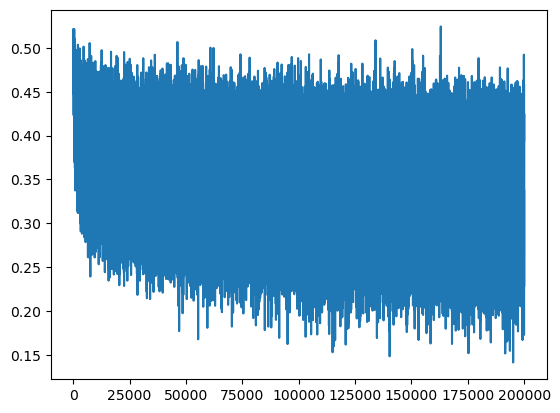

In [38]:
plt.plot(lossi)
# we see quite a noise in steps, its because of random batches of 32, to reduce noise could increase number of batches to 64 or more
# to make it look more linear

In [39]:
# calibrate the batch norm at the end of the training 
# so we could test our examples and could do it to different sizes, can be 1 sample 
# and we don't need to take batch and do always  dynamic batch normalization

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean and std of the entrie training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

# its very similar value sot bnmean_running and bnstd_running, and thats how most frameworks do actually, calculate the running

In [42]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # dynamic batch normalization at test time
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.129507303237915
val 2.1528100967407227


loss log

##### fix softmax 
train 2.1438074111938477
val 2.178218364715576
##### fix tanh  layer too saturated 
train 2.0981547832489014
val 2.134186029434204
##### fix using kaiming_normal_
train 2.099327564239502
val 2.1381168365478516
##### fix using batch normalization
train 2.129476547241211
val 2.1524293422698975

with running use:

train 2.129507303237915
val 2.1528100967407227

In [27]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass for neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      embcat = emb.view(1, -1) # concat into (1, block_size * n_embd)
      h = torch.tanh(embcat @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution 
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples 
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special  '.'  token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print generated word

carlaizabelle.
khy.
mili.
taty.
skanden.
jazonte.
deliah.
jareei.
nellara.
chaiivin.
leigh.
ham.
jor.
dessan.
saline.
livebi.
wayth.
giaarixi.
jaxeelinsa.
med.


# SUMMARY + PYTORCHIFYING -----------

In [7]:
# pytorchifing the code yayayayaya

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False),  BatchNorm1d(vocab_size), 
]

# layers = [
#     Linear(n_embd * block_size, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size) 
# ]

with torch.no_grad():
    #last layer make less confident
    # layers[-1].weight *= 0.1 # linear layer last
    layers[-1].gamma *= 0.1 # batchnorm layer last
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=  5/3 # because tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True
    

47024


In [8]:
# same optimization last time 
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  # take random 32 examples to use in training
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # [32,3,10] - embed characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors - [32, 30]
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #  loss function 
    
    # backward pass
    # for layer in layers:
    #     layer.out.retain_grad() # AFTER DEBUG would take out retain grad
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update 
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
    #     break  # After DEBUG would take out obviously to run full optimisation 

      0/ 200000: 3.2870
  10000/ 200000: 2.3578
  20000/ 200000: 2.1043
  30000/ 200000: 1.9646
  40000/ 200000: 2.2144
  50000/ 200000: 2.2264
  60000/ 200000: 1.7339
  70000/ 200000: 2.1747
  80000/ 200000: 2.1895
  90000/ 200000: 1.8282
 100000/ 200000: 2.3638
 110000/ 200000: 2.2019
 120000/ 200000: 2.1034
 130000/ 200000: 1.8565
 140000/ 200000: 1.8050
 150000/ 200000: 1.9258
 160000/ 200000: 1.8761
 170000/ 200000: 1.8333
 180000/ 200000: 2.2317
 190000/ 200000: 2.0516


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

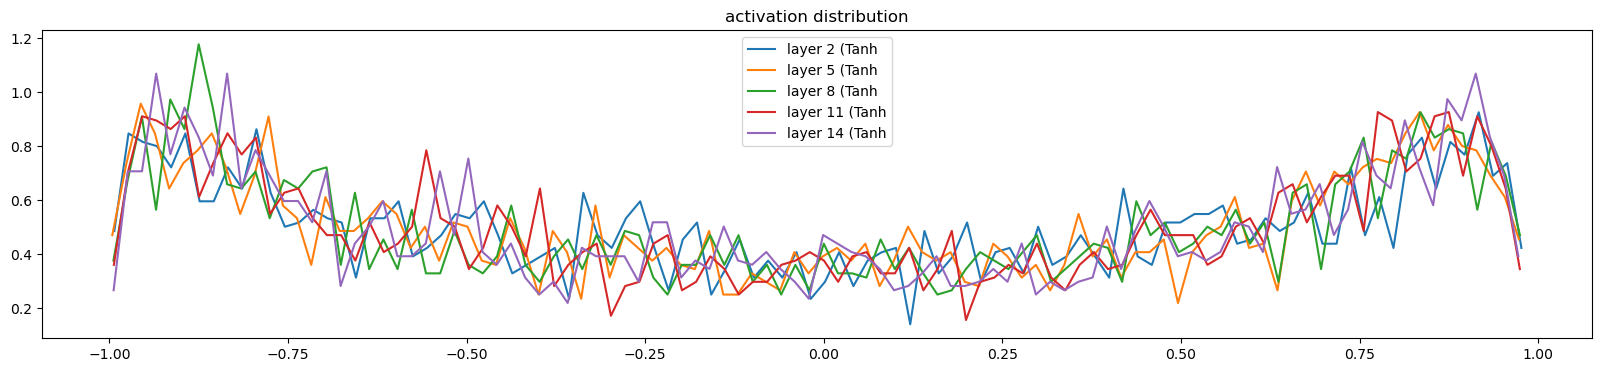

In [110]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.682952e-03
layer 5 (      Tanh): mean -0.000000, std 3.262607e-03
layer 8 (      Tanh): mean +0.000000, std 2.973730e-03
layer 11 (      Tanh): mean +0.000000, std 2.741109e-03
layer 14 (      Tanh): mean +0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

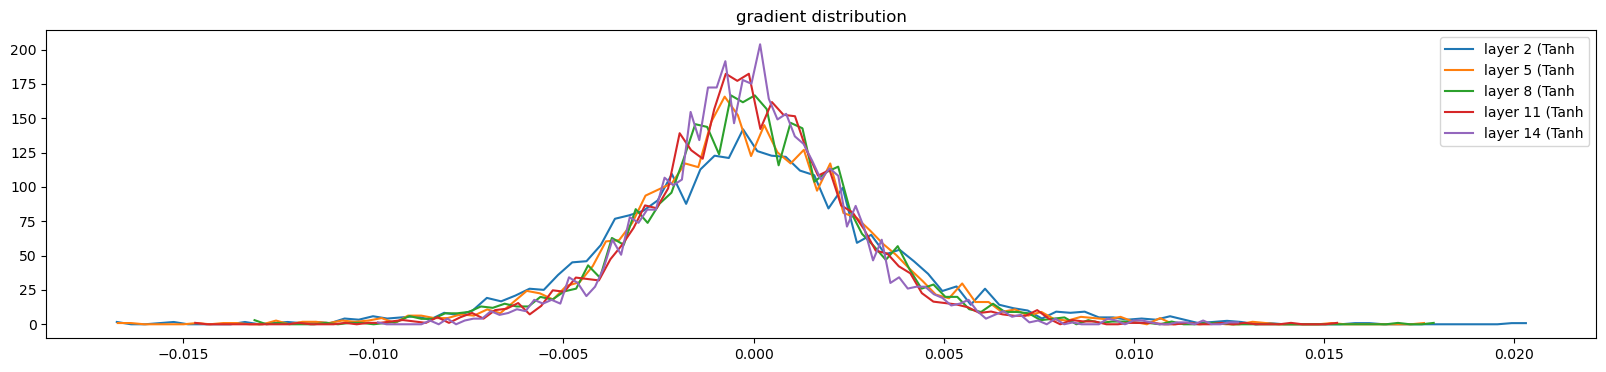

In [111]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.019885e-02 | grad:data ratio 1.018846e-02
weight  (30, 100) | mean +0.000092 | std 8.238429e-03 | grad:data ratio 2.635839e-02
weight (100, 100) | mean +0.000031 | std 7.318107e-03 | grad:data ratio 4.377141e-02
weight (100, 100) | mean -0.000019 | std 6.662021e-03 | grad:data ratio 3.949894e-02
weight (100, 100) | mean -0.000019 | std 5.821515e-03 | grad:data ratio 3.468160e-02
weight (100, 100) | mean +0.000053 | std 5.445295e-03 | grad:data ratio 3.243366e-02
weight  (100, 27) | mean -0.000165 | std 1.046844e-02 | grad:data ratio 6.281261e-02


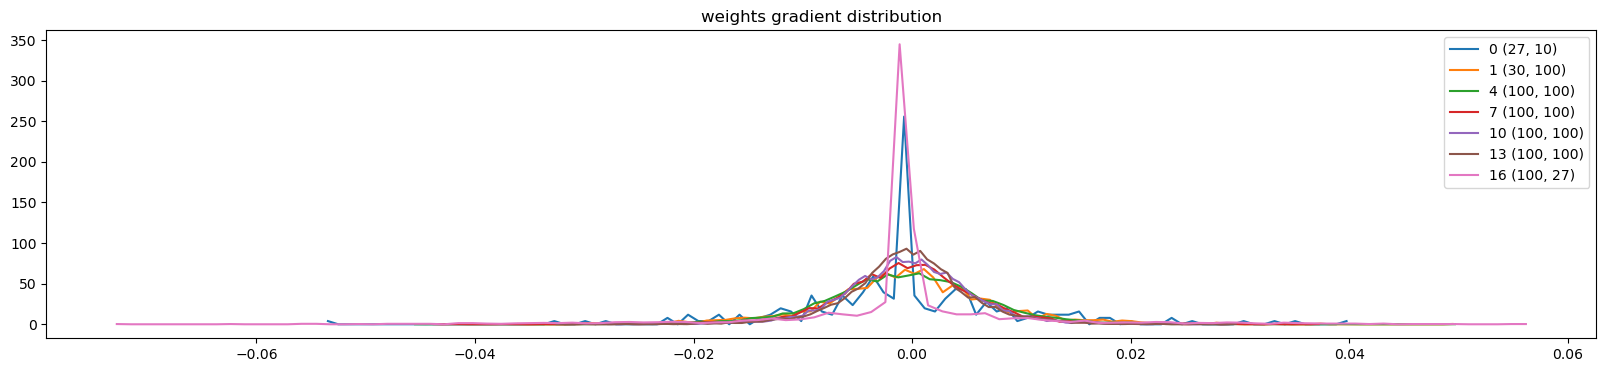

In [112]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

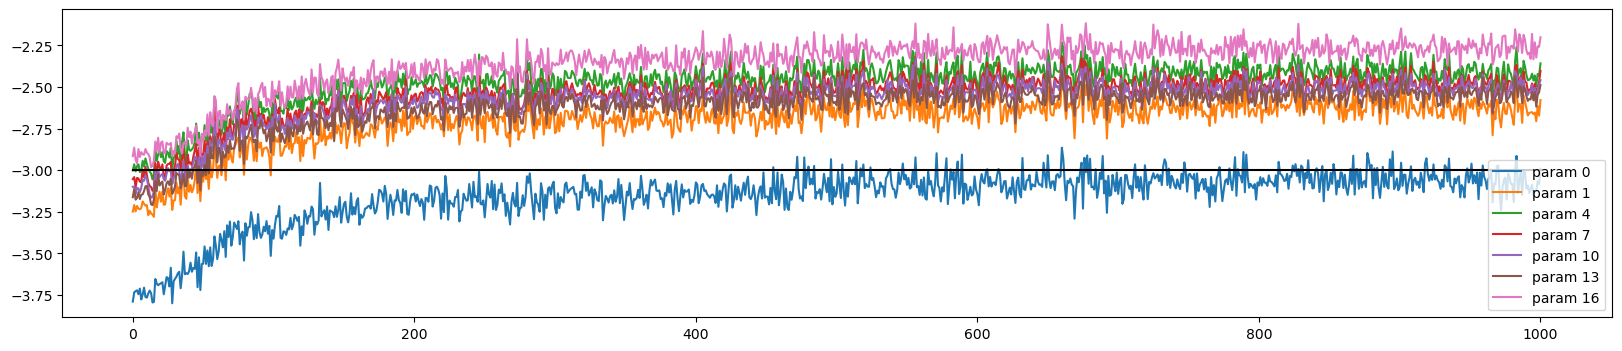

In [113]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.012321949005127
val 2.084083318710327


In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amelle.
khyriri.
reity.
skanya.
eja.
hube.
deliah.
jareei.
nellara.
chaiir.
kaleigh.
ham.
joce.
quintis.
lilah.
jadiquinte.
madiaryn.
kai.
eupitraylen.
